<a href="https://colab.research.google.com/github/FarhadKhankishiyev068/Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installing necessary library
!pip install lime

# Importing necessary libraries for my project
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the path to the dataset
data_dir = '/content/drive/My Drive/animals'  # Update this path to your dataset location
classes = ['zebra', 'buffalo', 'elephant', 'rhino']

# Display the structure of the dataset
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    print(f"{cls} contains {len(os.listdir(class_dir))} images")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=553d798445d2a924add6bd09a5cf0704ec860aa74ffe73a59ba97507f3254a3f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
zebra contains 752 images
buffalo contains 752 images
elephant contains 752 images
rhino contains 752 images


## Data Preprocessing
In this section, I will load the dataset, perform data augmentation, and split it into training and validation sets.
Data augmentation is crucial for improving the robustness of the model by artificially increasing the diversity of the training data.


In [3]:
def create_generators(data_dir, target_size=(32, 32), batch_size=32, validation_split=0.2):
    """
    Create training and validation data generators with data augmentation.
    """
    datagen = ImageDataGenerator(
        rescale=1./255,          # Normalize the pixel values to [0, 1]
        shear_range=0.2,         # Apply shear transformations
        zoom_range=0.2,          # Apply zoom transformations
        horizontal_flip=True,    # Apply horizontal flip
        validation_split=validation_split)  # Use specified percentage of data for validation

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,   # Resize images to target size
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')         # Set as training data

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,   # Resize images to target size
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')       # Set as validation data

    return train_gen, val_gen

# Creating training and validation generators
train_generator, validation_generator = create_generators(data_dir)


Found 1204 images belonging to 4 classes.
Found 300 images belonging to 4 classes.


## Model Training
I will define and train a simple Softmax Regression model using Keras.
Softmax Regression is a generalization of logistic regression to multiple classes.


In [ ]:
def build_and_train_model(train_gen, val_gen, epochs=65):
    """
    Build and train the Softmax Regression model.
    """
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),  # Flatten the input images
        Dense(4, activation='softmax')     # Output layer with 4 neurons (one for each class) and softmax activation
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs  # Training for the specified number of epochs
    )

    return model, history

# Build and train the model
softmax_model, softmax_history = build_and_train_model(train_generator, validation_generator)

# Evaluate the model
scores = softmax_model.evaluate(validation_generator)
print(f"Validation Accuracy: {scores[1]*100:.2f}%")


Epoch 1/65
38/38 [==============================] - ETA: 0s - loss: 1.4649 - accuracy: 0.3322

## Model Evaluation
After training the model, I will evaluate its performance using accuracy and loss plots.
This helps in understanding how well the model is performing on training and validation data over epochs.


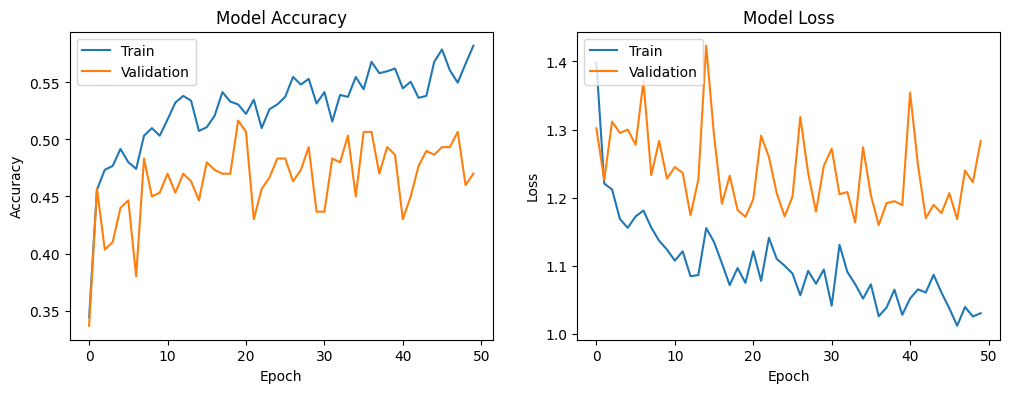

In [ ]:
def plot_metrics(history):
    """
    Plot training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot metrics
plot_metrics(softmax_history)


## Confusion Matrix and Classification Report
To gain deeper insights into the model's performance, I will analyze the confusion matrix and generate a classification report.
The confusion matrix will show the number of correct and incorrect predictions for each class, and the classification report will provide precision, recall, and F1-score for each class.


10/10 [==============================] - 8s 816ms/step


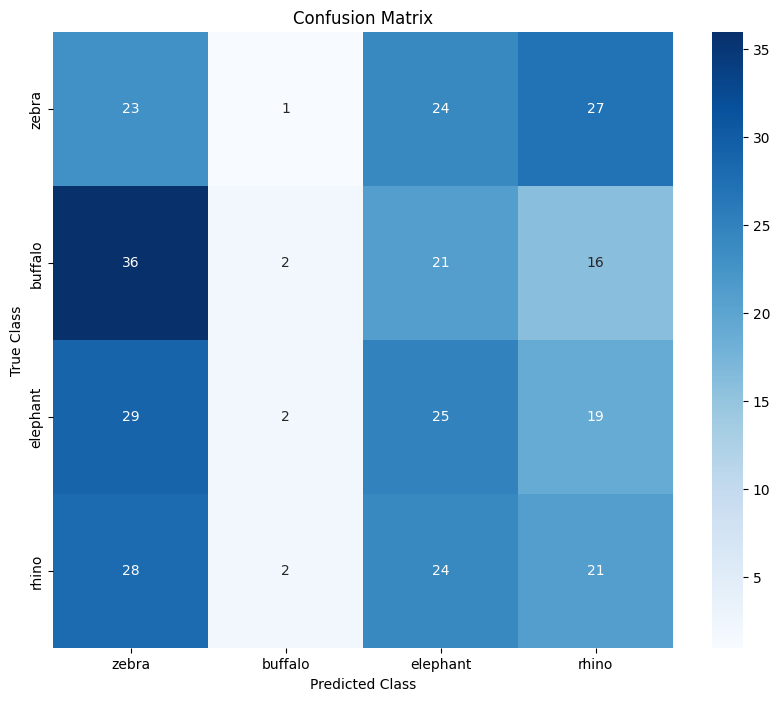

              precision    recall  f1-score   support

       zebra       0.20      0.31      0.24        75
     buffalo       0.29      0.03      0.05        75
    elephant       0.27      0.33      0.30        75
       rhino       0.25      0.28      0.27        75

    accuracy                           0.24       300
   macro avg       0.25      0.24      0.21       300
weighted avg       0.25      0.24      0.21       300



In [ ]:
def evaluate_model(model, val_gen, classes):
    """
    Evaluate the model using confusion matrix and classification report.
    """
    y_pred = model.predict(val_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_gen.classes

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    # Generate Classification Report
    class_report = classification_report(y_true, y_pred_classes, target_names=classes)
    print(class_report)

# Evaluate the model
evaluate_model(softmax_model, validation_generator, classes)


## Predictions with Confidence Levels
This section includes the function to predict the class of an image along with the confidence levels.


1/1 [==============================] - 0s 91ms/step
Predicted Class: rhino
Confidence: 0.51


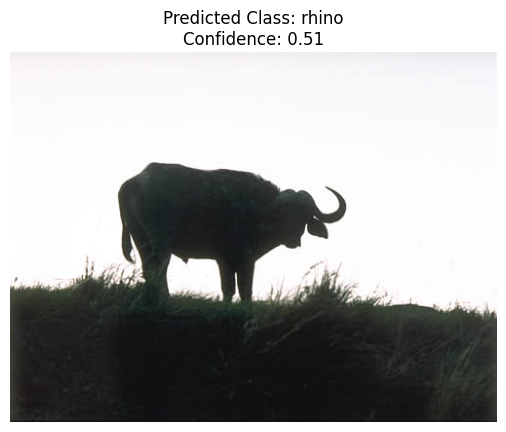

In [ ]:
def predict_image_class(img_path, model, class_labels):
    """
    Predict the class of an image using the trained model and display the confidence level.
    """
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0

    # Predict class probabilities
    class_probabilities = model.predict(img_array)
    predicted_class_index = np.argmax(class_probabilities)

    # Check if the predicted_class_index is in class_labels
    if predicted_class_index in class_labels:
        predicted_class_label = class_labels[predicted_class_index]
        confidence = class_probabilities[0][predicted_class_index]

        # Print predicted class and confidence
        print(f"Predicted Class: {predicted_class_label}")
        print(f"Confidence: {confidence:.2f}")

        # Display the image with predicted class and confidence as title
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class_label}\nConfidence: {confidence:.2f}")
        plt.show()
    else:
        print(f"Predicted class index {predicted_class_index} not found in class_labels.")

# Example prediction
sample_img_path = '/content/drive/My Drive/animals/buffalo/006.jpg'  # Update with an actual image path
class_labels = {0: 'zebra', 1: 'buffalo', 2: 'elephant', 3: 'rhino'}
predict_image_class(sample_img_path, softmax_model, class_labels)


## LIME Explanations
Despite achieving high accuracy, the model sometimes misclassifies images.
To understand why these misclassifications occur, I will use LIME (Local Interpretable Model-agnostic Explanations) to generate explanations for the model's predictions.
LIME helps in interpreting complex models by approximating them locally with interpretable models.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


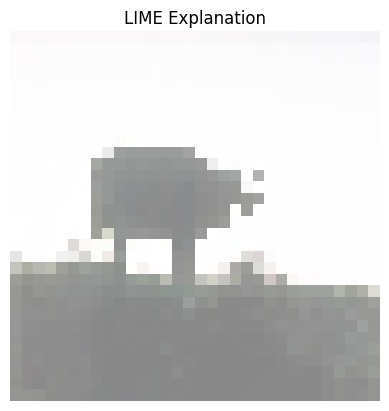

In [ ]:
def generate_lime_explanation(img_path, model, num_samples=1000, top_labels=4):
    """
    Generate explanations using LIME for the given image.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0

    # Create LIME explainer
    explainer = lime.lime_image.LimeImageExplainer()

    # Generate explanations
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=top_labels, hide_color=0, num_samples=num_samples)

    # Get the explanation mask
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    # Overlay the mask onto the original image
    overlay = mark_boundaries(temp / 2 + 0.5, mask)

    # Display the overlay image
    plt.imshow(overlay)
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Example path to the misclassified images
misclassified_images = ['/content/drive/My Drive/animals/buffalo/006.jpg']  # Update path to actual misclassified images

# Generating explanations for misclassified images
for img_file in misclassified_images:
    generate_lime_explanation(img_file, softmax_model)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_cnn_model():
    """
    Build a CNN model using transfer learning with VGG16.
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the CNN model
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=50)

# Evaluate the CNN model


Epoch 1/50
38/38 [==============================] - 46s 1s/step - loss: 1.2042 - accuracy: 0.4601 - val_loss: 1.1626 - val_accuracy: 0.4800
Epoch 2/50
38/38 [==============================] - 39s 1s/step - loss: 1.0692 - accuracy: 0.5357 - val_loss: 1.0631 - val_accuracy: 0.5300
Epoch 3/50
38/38 [==============================] - 44s 1s/step - loss: 0.9756 - accuracy: 0.6013 - val_loss: 1.0022 - val_accuracy: 0.5800
Epoch 4/50
38/38 [==============================] - 43s 1s/step - loss: 0.9004 - accuracy: 0.6188 - val_loss: 1.0029 - val_accuracy: 0.5567
Epoch 5/50
38/38 [==============================] - 43s 1s/step - loss: 0.8802 - accuracy: 0.6337 - val_loss: 1.0165 - val_accuracy: 0.5700
Epoch 6/50
38/38 [==============================] - 39s 1s/step - loss: 0.8512 - accuracy: 0.6537 - val_loss: 1.0174 - val_accuracy: 0.6000
Epoch 7/50
38/38 [==============================] - 42s 1s/step - loss: 0.8498 - accuracy: 0.6495 - val_loss: 1.0592 - val_accuracy: 0.5567
Epoch 8/50
38/38 [==

In [1]:
# Plot metrics for CNN model
plot_metrics(cnn_history)

# Evaluate the CNN model
evaluate_model(cnn_model, validation_generator, classes)

# Perform detailed error analysis on the CNN model
detailed_error_analysis(cnn_model, validation_generator, classes)


NameError: name 'plot_metrics' is not defined